# Best Model and Final Thoughts

In this notebook I will be presenting the best model from the 03_Modeling notebook, evaluating it, and providing my final thoughts and conclusions.

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer

import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_colwidth = 400

In [2]:
df = pd.read_csv('../data/cleaned/prepped_posts_with_count.csv', na_filter=False)
df.head(3)

,title,selftext,subreddit,created_utc,all_text,word_count
0,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,,1,1646141490,Germany Aims To Get 100% of Energy From Renewable Sources By 2035,12
1,Ambiental Dedetização - Dedetizadora e controle de Pragas,,1,1646140604,Ambiental Dedetização - Dedetizadora e controle de Pragas,8
2,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",,1,1646138910,"Alcohol use by parents of young children was related to how many bars and restaurants were near where they shopped, where they worked and where their children went to school, a new study finds.",34


In [3]:
X = df.drop(columns='subreddit')
y = df['subreddit']

In [4]:
y.value_counts(normalize=True)

1    0.500501
0    0.499499
Name: subreddit, dtype: float64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [6]:
def get_word_count_col(df):
    return df[['word_count']]

def get_all_text_col(df):
    return df['all_text']

get_word_count_col_tf = FunctionTransformer(get_word_count_col, validate=False)
get_all_text_col_tf = FunctionTransformer(get_all_text_col, validate=False)

In [7]:
word_count_pipe = Pipeline([
    ('word_count', get_word_count_col_tf),
])

all_text_pipe = Pipeline([
    ('all_text', get_all_text_col_tf),
    ('vect', TfidfVectorizer()),
])

In [8]:
feature_union = FeatureUnion([
    ('count', word_count_pipe),
    ('text', all_text_pipe),
])

In [9]:
pipe = Pipeline([
    ('features', feature_union),
    ('logreg', LogisticRegression(max_iter=10_000))
])

In [10]:
params={
    'features__text__vect__stop_words': [['til']],
    'features__text__vect__min_df':[1],
    'features__text__vect__max_df': [.5],
    'features__text__vect__binary': [False],
    'features__text__vect__ngram_range': [(1,2)],
    'logreg__solver': ['saga'],
    'logreg__penalty': ['none']
}
best_model = RandomizedSearchCV(pipe, param_distributions=params, random_state=42)
best_model.fit(X_train, y_train)

print('Training Score: '+str(best_model.best_score_))
print('Test Score: '+str(best_model.score(X_test, y_test)))
print(classification_report(y_test, best_model.predict(X_test)))

Training Score: 0.8780638455827765
Test Score: 0.8866666666666667
              precision    recall  f1-score   support

           0       0.91      0.86      0.88       375
           1       0.87      0.91      0.89       375

    accuracy                           0.89       750
   macro avg       0.89      0.89      0.89       750
weighted avg       0.89      0.89      0.89       750



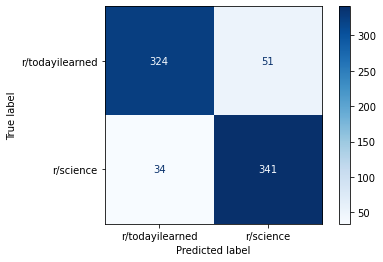

In [11]:
plot_confusion_matrix(best_model, X_test, y_test,
                      display_labels=['r/todayilearned', 'r/science'], cmap='Blues');

# Final Thoughts and Conclusions


The above model is pretty good at determining which subreddit a post belongs to. It is 89% accurate and the false positives and false negatives are pretty balanced and not heavily skewed one way or the other. The word count doesn't help a whole lot, but it did improve it some, so I am glad to keep it in.


What I am curious about is how this model will perform in the future. Due to the timing of this project, I pulled posts as a major conflict was occuring in Ukraine, which pretty much took over every subreddit, including r/todayilearned. That may have made it easier for the model to classify each subreddit since there was a more consistent theme for the posts. If I had pulled the posts prior to the conflict, I may have had a worse model since r/todayilearned may have been more diverse. I believe r/science would be pretty similar to what I pulled, so that effect on the model may be unchanged.


The other thing I wanted to note was that I am glad I was able to get such a high accuracy rate even with adding 'til' to the stop words. 'TIL' would have been a dead giveaway that the post was from r/todayilearned. Not every post had it, but more than 75% did when I explored the data. Adding it back in would probably be a major boost that could get the accuracy easily over 90%.

# Next Steps


There are couple of things that could be done to expand on this project. There are a ton of different models that I was taught towards the end of the week that I could use to get predictions that may be even more accurate. I also tried working with regular expressions and custom tokenizers to no success, so if I had more time I could explore those more. 


If I wanted to keep the same model, I would wait a couple of months and try the same subreddits again to see how it would perform. I think r/science would be about the same but I'm curious as to what the top words would be like for r/todayilearned after the Ukraine war is over. I would think the model accuracy would go down, but the nature of r/todayilearned is such that any major world event could easily generate a lot of posts there, making something like 'pineapple' (maybe a rainbow pineapple is grown or something?) take over the top spot for a week or so as redditers learn more about pineapples.

All in all, I am happy with how the project turned out, but I would like to have had more time to try newer models and maybe gather even more posts to better train the models with.